In [1]:
%matplotlib inline
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import collections
import re, string
import sys
import time
import json
from nltk.corpus import stopwords
from subprocess import check_output
%matplotlib inline

In [2]:
def init_ds(json):
    ds = {}
    keys = json.keys()
    for k in keys:
        ds[k] = []
    return ds, keys

def read_json(file):
    dataset = {}
    keys = []
    with open(file, encoding = "utf8") as file_lines:
        for count, line in enumerate(file_lines):
            data = json.loads(line.strip())
            if count == 0:
                dataset, keys = init_ds(data)
            for k in keys:
                dataset[k].append(data[k])
        return pd.DataFrame(dataset)

In [4]:
%%time
yelp_business = read_json(r'C:/Users/adity/Downloads/Courses/CS396 - Data Science Pipeline/Yelp_Dataset/business.json')
yelp_review = read_json(r'C:/Users/adity/Downloads/Courses/CS396 - Data Science Pipeline/Yelp_Dataset/review.json')

Wall time: 9min 6s


In [5]:
import warnings;
warnings.filterwarnings('ignore')

# EDA CHECKPOINT

In [6]:
yelp_review.business_id.value_counts()

4JNXUYY8wbaaDmk3BPzlWw    8570
RESDUcs7fIiihp38-d6_6g    8568
K7lWdNUhCbcnEvI0NhGewg    6887
f4x1YBxkLrZg652xt2KR5g    5847
cYwJA2A6I12KNkm2rtXd5g    5575
                          ... 
tBykEX1OSrFWH3-wGgeKVQ       3
69CmeOIoEr0J4LceK1xXZQ       3
Y7ps6qXrKwlMOUFZlzY-1Q       3
IQ-Vv0Pg2e-AYQCsAU4jDw       3
VnpZg4h3O5AlcMjJYErowA       2
Name: business_id, Length: 192606, dtype: int64

In [48]:
bottom_reviewed = yelp_review[yelp_review["stars"] < 2]
bottom_reviews_dict = {} 

for business_id in bottom_reviewed["business_id"].values:
    try:
        bottom_reviews_dict[business_id] = bottom_reviews_dict[business_id] + 1
    except:
        bottom_reviews_dict[business_id] = 1
        
bottombusiness = pd.DataFrame.from_dict(data = bottom_reviews_dict, orient = "index")
bottombusiness.reset_index(inplace = True)
bottombusiness.columns = ['business_id', 'rated']

In [49]:
right = pd.DataFrame(yelp_business[['business_id', "name", "categories"]].values, columns = ['business_id', "Business name", "categories"])
bottom_business_data = pd.merge(bottombusiness, right = right, how = "inner", on = 'business_id')

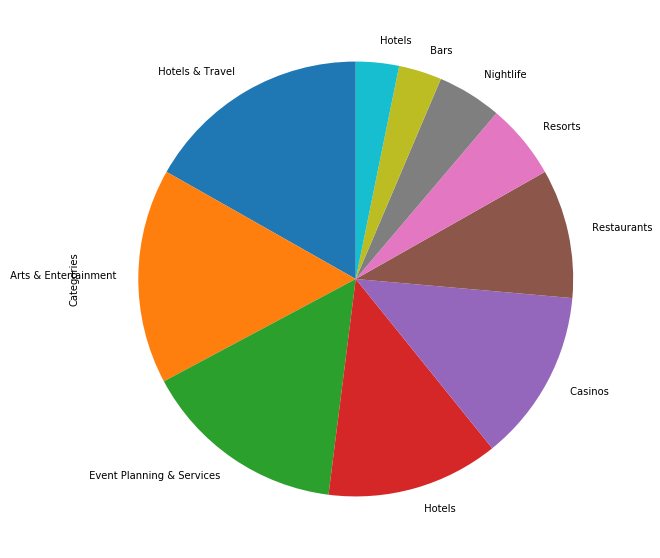

In [50]:
num_cat = 10
bottom_business = 30 # choose categories of top 30 businesses
cat_data = bottom_business_data.sort_values("rated")[::-1][:bottom_business]

Categories = {}
for cat in cat_data.categories.values:
    all_categories = cat.split(",")
    for x in all_categories:
        try:
            Categories[x] = Categories[x] + 1
        except:
            Categories[x] = 1
bottom_categories = pd.DataFrame.from_dict(data = Categories, orient = "index")
bottom_categories.reset_index(inplace = True)
bottom_categories.columns = ['category', 'occurance']

x_val = bottom_categories.sort_values("occurance")[::-1][:num_cat].occurance.values
labels = bottom_categories.sort_values("occurance")[::-1][:num_cat].category.values
series = pd.Series(x_val, index = labels, name = 'Categories')
series.plot.pie(figsize = (10, 10), startangle = 90)

In [51]:
close_busi_df = pd.DataFrame(yelp_business[yelp_business['is_open'] == 0][['business_id', "review_count", "stars"]].values, columns = ['business_id', "Reviews_no", "stars"])

In [52]:
open_busi_df = pd.DataFrame(yelp_business[yelp_business['is_open'] == 1][['business_id', "review_count", "stars"]].values, columns = ['business_id', "Reviews_no", "stars"])

In [53]:
open_rev_df = pd.DataFrame(yelp_review[['business_id', "useful", "funny", "cool"]].values, columns = ['business_id', "useful", "funny", "cool"])
open_rev_data = open_rev_df.groupby(["business_id"])
test = open_rev_data.aggregate(np.sum)
open_business = pd.merge(open_busi_df, right = test, how = "inner", on = 'business_id')
open_business['stars'] = open_business['stars'].astype(float)
open_business['Reviews_no'] = open_business['Reviews_no'].astype(float)
open_bus_conc = open_business.mean()
open_bus_conc

Reviews_no    35.496152
stars          3.609770
useful        48.788263
funny         17.017121
cool          20.782825
dtype: float64

In [54]:
close_business = pd.merge(close_busi_df, right = test, how = "inner", on = 'business_id')
close_business['stars'] = close_business['stars'].astype(float)
close_business['Reviews_no'] = close_business['Reviews_no'].astype(float)
close_bus_conc = close_business.mean()
close_bus_conc

Reviews_no    24.438358
stars          3.473257
useful        38.715849
funny         15.553984
cool          16.872110
dtype: float64

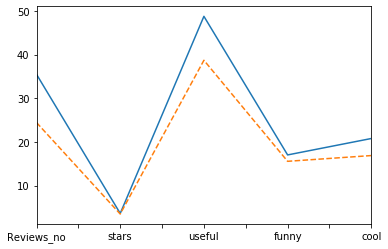

<Figure size 1440x1224 with 0 Axes>

In [55]:
fig, ax = plt.subplots()
plt.figure(figsize = (20,17))
ax = open_bus_conc.plot(y = ["Reviews_no", "stars", "useful", "funny", "cool"], ax = ax)
close_bus_conc.plot(y = ["Reviews_no", "stars", "useful", "funny", "cool"], ax = ax, ls = "--")
plt.show()bus_df = yelp_business

# checking how many businesses are open / closed (158525 / 34084)
bus_df.is_open.value_counts()

In [56]:
bus_df = yelp_business

# checking how many businesses are open / closed (158525 / 34084)
bus_df.is_open.value_counts()

1    158525
0     34084
Name: is_open, dtype: int64

In [57]:
# checking mean stars rating for closed / open (3.47 / 3.61)
bus_df.groupby('is_open', as_index = False)['stars'].mean()

,is_open,stars
0,0,3.473257
1,1,3.609787


In [58]:
# checking mean review count for closed / open (24.44 / 35.5)
bus_df.groupby('is_open', as_index = False)['review_count'].mean()

,is_open,review_count
0,0,24.438358
1,1,35.495657


In [59]:
# filtering for closed businesses
bus_df_closed = bus_df[bus_df['is_open'] == 0]

# identifying postal codes which have most closed businesses
bus_df_closed_pc_1 = bus_df_closed.groupby(['is_open', 'state', 'postal_code'], as_index = False)['business_id'].count().max(level = 0)

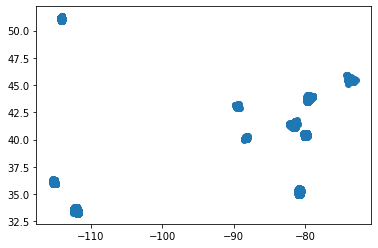

In [60]:
# overall level checking where are the closed businesses on the map
plt.scatter(x = bus_df_closed['longitude'], y = bus_df_closed['latitude'])
plt.show()

In [61]:
# list of states with closed businesses
bus_df_closed.state.unique()

array(['AZ', 'NV', 'ON', 'NC', 'AB', 'QC', 'PA', 'OH', 'IL', 'WI', 'SC',
       'CA', 'AK', 'TX', 'WA', 'FL'], dtype=object)

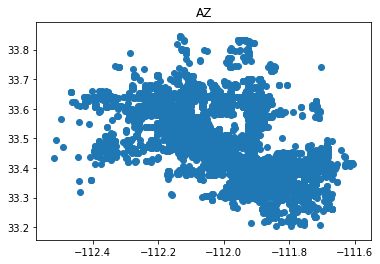

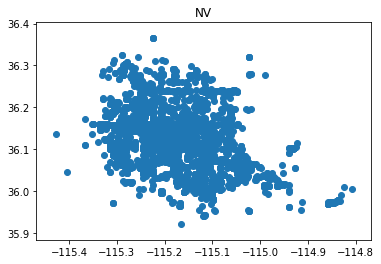

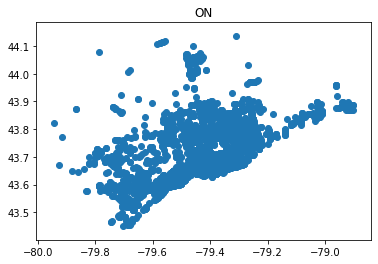

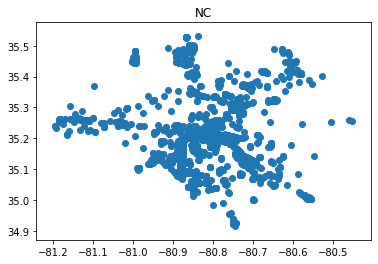

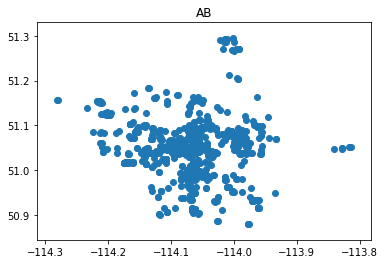

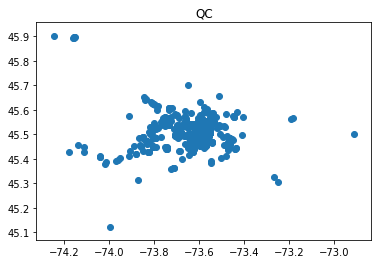

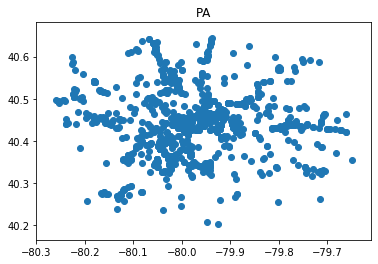

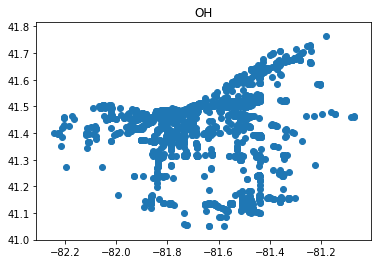

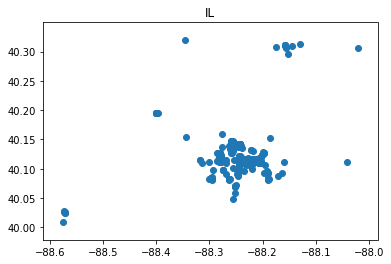

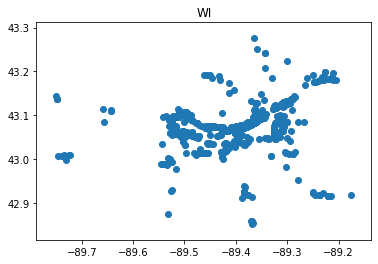

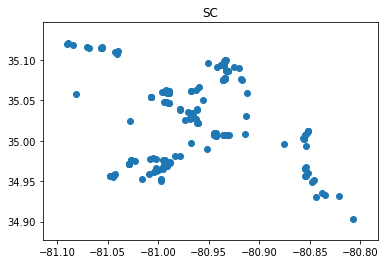

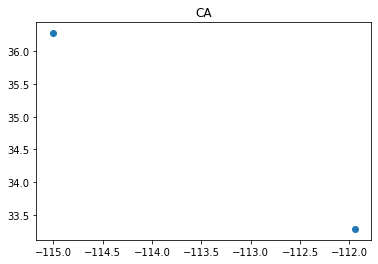

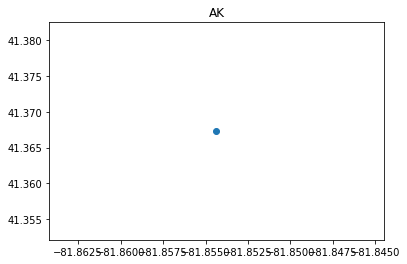

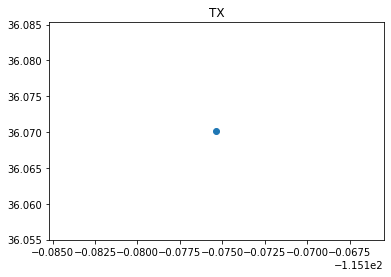

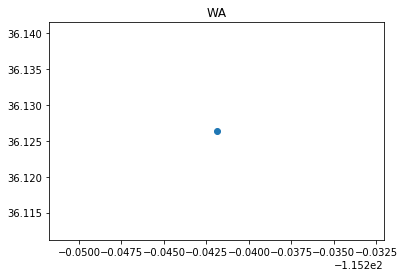

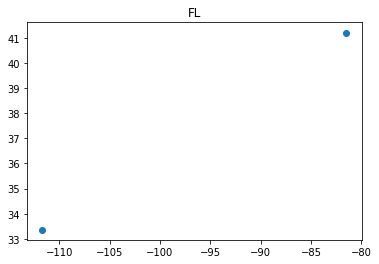

In [62]:
# plotting closed businesses' latitude and longitude to see if there are certain areas that have reason to be troublesome for businesses
bus_df_closed_ll = bus_df[(bus_df['is_open'] == 0) & (bus_df['state'] == "AZ")]
plt.scatter( x = bus_df_closed_ll['longitude'], y = bus_df_closed_ll['latitude'])
plt.title('AZ')
plt.show()

bus_df_closed_ll = bus_df[(bus_df['is_open'] == 0) & (bus_df['state'] == 'NV')]
plt.scatter(x = bus_df_closed_ll['longitude'], y = bus_df_closed_ll['latitude'])
plt.title('NV')
plt.show()

bus_df_closed_ll = bus_df[(bus_df['is_open'] == 0) & (bus_df['state'] == 'ON')]
plt.scatter(x = bus_df_closed_ll['longitude'], y = bus_df_closed_ll['latitude'])
plt.title('ON')
plt.show()

bus_df_closed_ll = bus_df[(bus_df['is_open'] == 0) & (bus_df['state'] == 'NC')]
plt.scatter(x = bus_df_closed_ll['longitude'], y = bus_df_closed_ll['latitude'])
plt.title('NC')
plt.show()

bus_df_closed_ll = bus_df[(bus_df['is_open'] == 0) & (bus_df['state'] == 'AB')]
plt.scatter(x = bus_df_closed_ll['longitude'], y = bus_df_closed_ll['latitude'])
plt.title('AB')
plt.show()

bus_df_closed_ll = bus_df[(bus_df['is_open'] == 0) & (bus_df['state'] == 'QC')]
plt.scatter(x = bus_df_closed_ll['longitude'], y = bus_df_closed_ll['latitude'])
plt.title('QC')
plt.show()

bus_df_closed_ll = bus_df[(bus_df['is_open'] == 0) & (bus_df['state'] == 'PA')]
plt.scatter(x = bus_df_closed_ll['longitude'], y = bus_df_closed_ll['latitude'])
plt.title('PA')
plt.show()

bus_df_closed_ll = bus_df[(bus_df['is_open'] == 0) & (bus_df['state'] == 'OH')]
plt.scatter(x = bus_df_closed_ll['longitude'], y = bus_df_closed_ll['latitude'])
plt.title('OH')
plt.show()

bus_df_closed_ll = bus_df[(bus_df['is_open'] == 0) & (bus_df['state'] == 'IL')]
plt.scatter(x = bus_df_closed_ll['longitude'], y = bus_df_closed_ll['latitude'])
plt.title('IL')
plt.show()

bus_df_closed_ll = bus_df[(bus_df['is_open'] == 0) & (bus_df['state'] == 'WI')]
plt.scatter(x = bus_df_closed_ll['longitude'], y = bus_df_closed_ll['latitude'])
plt.title('WI')
plt.show()

bus_df_closed_ll = bus_df[(bus_df['is_open'] == 0) & (bus_df['state'] == 'SC')]
plt.scatter(x = bus_df_closed_ll['longitude'], y = bus_df_closed_ll['latitude'])
plt.title('SC')
plt.show()

bus_df_closed_ll = bus_df[(bus_df['is_open'] == 0) & (bus_df['state'] == 'CA')]
plt.scatter(x = bus_df_closed_ll['longitude'], y = bus_df_closed_ll['latitude'])
plt.title('CA')
plt.show()

bus_df_closed_ll = bus_df[(bus_df['is_open'] == 0) & (bus_df['state'] == 'AK')]
plt.scatter(x = bus_df_closed_ll['longitude'], y = bus_df_closed_ll['latitude'])
plt.title('AK')
plt.show()

bus_df_closed_ll = bus_df[(bus_df['is_open'] == 0) & (bus_df['state'] == 'TX')]
plt.scatter(x = bus_df_closed_ll['longitude'], y = bus_df_closed_ll['latitude'])
plt.title('TX')
plt.show()

bus_df_closed_ll = bus_df[(bus_df['is_open'] == 0) & (bus_df['state'] == 'WA')]
plt.scatter(x = bus_df_closed_ll['longitude'], y = bus_df_closed_ll['latitude'])
plt.title('WA')
plt.show()

bus_df_closed_ll = bus_df[(bus_df['is_open'] == 0) & (bus_df['state'] == 'FL')]
plt.scatter(x = bus_df_closed_ll['longitude'], y = bus_df_closed_ll['latitude'])
plt.title('FL')
plt.show()

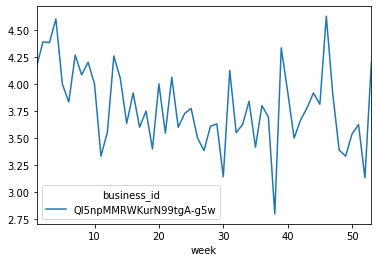

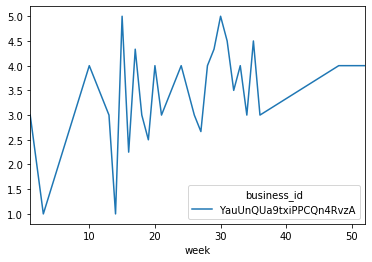

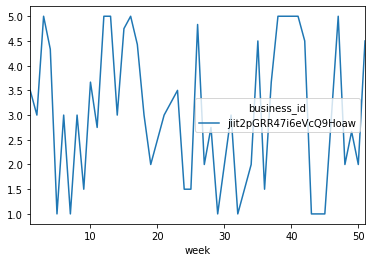

In [63]:
rev_df = yelp_review
# plotting stars for closed businesses
rev_df['date'] = pd.to_datetime(rev_df['date'])

rev_df['date'].head()

rev_df_closed_1 = rev_df[rev_df['business_id'] == 'Ql5npMMRWKurN99tgA-g5w']
rev_df_closed_1['week'] = rev_df_closed_1['date'].dt.week
# use unstack()
rev_df_closed_1.groupby(['week','business_id']).mean()['stars'].unstack().plot()

rev_df_closed_2 = rev_df[rev_df['business_id'] == 'YauUnQUa9txiPPCQn4RvzA']
rev_df_closed_2['week'] = rev_df_closed_2['date'].dt.week
# use unstack()
rev_df_closed_2.groupby(['week','business_id']).mean()['stars'].unstack().plot()

rev_df_closed_3 = rev_df[rev_df['business_id'] == 'jiit2pGRR47i6eVcQ9Hoaw']
rev_df_closed_3['week'] = rev_df_closed_3['date'].dt.week
# use unstack()
rev_df_closed_3.groupby(['week','business_id']).mean()['stars'].unstack().plot()

# ML CHECKPOINT

In [11]:
bus_df = pd.DataFrame(yelp_business[['business_id', "review_count", "stars", "is_open"]].values, columns = ['business_id', "review_count", "stars", "is_open"])

In [12]:
rev_df = pd.DataFrame(yelp_review[['business_id', "useful", "funny", "cool"]].values, columns = ['business_id', "useful", "funny", "cool"])

In [13]:
rev_df_2 = rev_df.groupby(["business_id"])

In [14]:
rev_df_3 = rev_df_2.aggregate(np.sum)

In [15]:
ml_df = pd.merge(bus_df, right = rev_df_3, how = "inner", on = 'business_id')

In [16]:
ml_df['stars'] = ml_df['stars'].astype(float)
ml_df['review_count'] = ml_df['review_count'].astype(float)
ml_df['is_open'] = ml_df['is_open'].astype(float)

In [17]:
ml_df = ml_df.dropna(subset = ['business_id', "review_count", "stars", "useful", "funny", "cool"])

In [14]:
X = ml_df[["review_count", "stars", "useful", "funny", "cool"]]
y = ml_df['is_open']

In [16]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
lg_model = LogisticRegression().fit(X, y)
lg_cv_score = cross_val_score(LogisticRegression(max_iter = 500), X, y, cv = 5, scoring = 'accuracy')
print(lg_cv_score)
print("Logistic regression classifier accuracy: ", lg_cv_score.mean())

[0.82290639 0.82254296 0.82297967 0.82282391 0.82294912]
Logistic regression classifier accuracy:  0.8228404117222488


In [17]:
from sklearn.naive_bayes import GaussianNB
gss_model = GaussianNB().fit(X, y)
gss_cv_score = cross_val_score(GaussianNB(), X, y, cv = 5, scoring = 'accuracy')
print("Gaussian Naive Bayes classifier accuracy: ", gss_cv_score.mean())

[0.50443902 0.81914231 0.82077308 0.82129228 0.82037902]
Gaussian Naive Bayes classifier accuracy:  0.7572051441950818


In [18]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
parameters = {'learning_rate': [pow(10, -1 * i) for i in range(0, 3)], 'max_depth':[3, 4]}
gbt_model = GridSearchCV(GradientBoostingClassifier(), parameters, scoring = 'accuracy')
gbt_model.fit(X, y)
gbt_model.cv_results_
print("Gradient Boosting Tree classifier accuracy: ", max(gbt_model.cv_results_['mean_test_score']))

Gradient Boosting Tree classifier accuracy:  0.8230377039136891


In [19]:
gbt_model_roc = GridSearchCV(GradientBoostingClassifier(), parameters, scoring = 'roc_auc')
gbt_model_roc.fit(X, y)
gbt_model_roc.cv_results_
print("Gradient Boosting Tree classifier accuracy (ROC - AUC): ", max(gbt_model_roc.cv_results_['mean_test_score']))

Gradient Boosting Tree classifier accuracy (ROC - AUC):  0.6450586112549693


In [20]:
from sklearn.neighbors import KNeighborsClassifier
knn_model = KNeighborsClassifier(n_neighbors = 5).fit(X, y)
knn_cv_score = cross_val_score(KNeighborsClassifier(n_neighbors = 5), X, y, cv = 5,scoring = 'accuracy')
print(knn_cv_score)
print("K Nearest Neighbors classifier accuracy: ", knn_cv_score.mean())

[0.79455895 0.78949691 0.79631889 0.79504686 0.79244548]
K Nearest Neighbors classifier accuracy:  0.7935734191200575


In [21]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

dtree_model = DecisionTreeClassifier(random_state = 0, max_depth = 5).fit(X, y)
dtree_cv_score = cross_val_score(DecisionTreeClassifier(random_state = 0, max_depth = 5), X, y, cv = 5, scoring = 'accuracy')
print(dtree_cv_score)
print("Decision Tree classifier accuracy: ", dtree_cv_score.mean())

rforest_model = RandomForestClassifier(max_depth = 5, n_estimators = 10).fit(X, y)
rforest_cv_score = cross_val_score(RandomForestClassifier(random_state = 0, max_depth = 3, max_features = 1), X, y, cv = 5, scoring = 'accuracy')
print(rforest_cv_score)
print("Random Forest classifier accuracy: ", rforest_cv_score.mean())

[0.82303619 0.82301023 0.82300563 0.82303159 0.82305296]
Decision Tree classifier accuracy:  0.8230273201970068
[0.82303619 0.82303619 0.82303159 0.82303159 0.82305296]
Random Forest classifier accuracy:  0.8230377040086461


In [22]:
from sklearn import linear_model
sgd_model = linear_model.SGDClassifier(max_iter = 1500, tol = 1e-3, penalty = 'l2').fit(X, y)
sgd_cv_score = cross_val_score(linear_model.SGDClassifier(max_iter = 1500, tol = 1e-3, penalty = 'l2'), X, y, cv = 5, scoring = 'accuracy')
print(sgd_cv_score)
print("SGD trained classifier accuracy: ", sgd_cv_score.mean())

[0.81392451 0.75045429 0.82209704 0.17743568 0.80246625]
SGD trained classifier accuracy:  0.6732755540482064


In [25]:
from sklearn.neural_network import MLPClassifier

mlp_model_sgd = MLPClassifier(solver = 'sgd', alpha = 1e-4, hidden_layer_sizes = (5, 3), random_state = 1).fit(X, y)
mlp_sgd_cv_score = cross_val_score(MLPClassifier(solver = 'sgd', alpha = 1e-4, hidden_layer_sizes = (5, 3), random_state = 1), X, y, cv = 5, scoring = 'accuracy')
print(mlp_sgd_cv_score)
print("Multi Layer Perceptron classifier accuracy (SGD): ", mlp_sgd_cv_score.mean())

[0.82303619 0.82303619 0.82303159 0.82297967 0.82305296]
Multi Layer Perceptron classifier accuracy (SGD):  0.8230273200622273


In [24]:
mlp_model_adam = MLPClassifier(solver = 'adam', alpha = 1e-4, hidden_layer_sizes = (5,5), random_state = 1).fit(X, y)
mlp_adam_cv_score = cross_val_score(MLPClassifier(solver = 'adam', alpha = 1e-4, hidden_layer_sizes = (5, 5), random_state = 1), X, y, cv = 5, scoring = 'accuracy')
print(mlp_adam_cv_score)
print("Multi Layer Perceptron classifier accuracy (ADAM): ", mlp_adam_cv_score.mean())

[0.82303619 0.82280255 0.82303159 0.82303159 0.823027  ]
Multi Layer Perceptron classifier accuracy (ADAM):  0.8229857853547802


In [18]:
yelp_tip = read_json(r'C:/Users/adity/Downloads/Courses/CS396 - Data Science Pipeline/Yelp_Dataset/tip.json')
yelp_photo = read_json(r'C:/Users/adity/Downloads/Courses/CS396 - Data Science Pipeline/Yelp_Dataset/photo.json')

In [19]:
tip_df = pd.DataFrame(yelp_tip[['business_id', "compliment_count"]].values, columns = ['business_id', "compliment_count"])
photo_df = pd.DataFrame(yelp_photo[['business_id', "photo_id"]].values, columns = ['business_id', "photo_id"])

In [20]:
tip_df['compliment_count'] = tip_df['compliment_count'].astype(float)
tip_df_2 = tip_df.groupby(["business_id"])
tip_df_3 = tip_df_2.aggregate(np.mean)

In [21]:
photo_df_2 = photo_df.groupby(["business_id"]).agg({"photo_id": ['count']})

In [22]:
ml_df_2 = pd.merge(ml_df, right = tip_df_3, how = "left", on = 'business_id')
ml_df_3 = pd.merge(ml_df_2, right = photo_df_2, how = "left", on = 'business_id')

In [23]:
ml_df_3.columns = ml_df_3.columns.fillna('photo_id')

In [24]:
ml_df_3.columns = ml_df_3.columns.str.replace("('photo_id', 'count')",'photo_id')

In [25]:
ml_df_3.columns = ml_df_3.columns.fillna('photo_id')

In [31]:
ml_df_3.fillna(0, inplace = True)
X_1 = ml_df_3[["review_count", "stars", "useful", "funny", "cool", "compliment_count", "photo_id"]]
y_1 = ml_df_3['is_open']

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
lg_model_1 = LogisticRegression().fit(X_1, y_1)
lg_cv_score_1 = cross_val_score(LogisticRegression(max_iter = 500), X_1, y_1, cv = 5, scoring = 'accuracy')
print(lg_cv_score_1)
print("Logistic regression classifier accuracy: ", lg_cv_score_1.mean())

[0.82282851 0.822517   0.82295371 0.82282391 0.82294912]
Logistic regression classifier accuracy:  0.8228144523953194


In [56]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingClassifier
parameters = {'learning_rate': [pow(10, -1 * i) for i in range(0, 3)], 'max_depth':[3, 4]}
gbt_model_1 = GridSearchCV(GradientBoostingClassifier(), parameters, scoring = 'accuracy')
gbt_model_1.fit(X_1, y_1)
gbt_model_1.cv_results_
print("Gradient Boosting Tree classifier accuracy: ", max(gbt_model_1.cv_results_['mean_test_score']))

Gradient Boosting Tree classifier accuracy:  0.8230688555912069


In [33]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
scaler = StandardScaler()
scaled_X_1 = scaler.fit_transform(X_1)
lg_model_2 = LogisticRegression().fit(scaled_X_1, y_1)
lg_cv_score_2 = cross_val_score(LogisticRegression(max_iter = 500), scaled_X_1, y_1, cv = 5, scoring = 'accuracy')
print(lg_cv_score_2)
print("Logistic regression classifier accuracy: ", lg_cv_score_2.mean())

[0.82285447 0.822517   0.82295371 0.82282391 0.82294912]
Logistic regression classifier accuracy:  0.8228196442337493


In [34]:
yelp_business_test = yelp_business

In [43]:
yelp_business_test['cnt_attr'] = yelp_business_test['attributes'].str.len()

In [44]:
yelp_business_test

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours,cnt_attr
0,1SWheh84yJXfytovILXOAQ,Arizona Biltmore Golf Club,2818 E Camino Acequia Drive,Phoenix,AZ,85016,33.522143,-112.018481,3.0,5,0,{'GoodForKids': 'False'},"Golf, Active Life",None,1.0
1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,30 Eglinton Avenue W,Mississauga,ON,L5R 3E7,43.605499,-79.652289,2.5,128,1,"{'RestaurantsReservations': 'True', 'GoodForMe...","Specialty Food, Restaurants, Dim Sum, Imported...","{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",18.0
2,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,"10110 Johnston Rd, Ste 15",Charlotte,NC,28210,35.092564,-80.859132,4.0,170,1,"{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...","Sushi Bars, Restaurants, Japanese","{'Monday': '17:30-21:30', 'Wednesday': '17:30-...",19.0
3,xvX2CttrVhyG2z1dFg_0xw,Farmers Insurance - Paul Lorenz,"15655 W Roosevelt St, Ste 237",Goodyear,AZ,85338,33.455613,-112.395596,5.0,3,1,None,"Insurance, Financial Services","{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...",NaN
4,HhyxOkGAM07SRYtlQ4wMFQ,Queen City Plumbing,"4209 Stuart Andrew Blvd, Ste F",Charlotte,NC,28217,35.190012,-80.887223,4.0,4,1,"{'BusinessAcceptsBitcoin': 'False', 'ByAppoint...","Plumbing, Shopping, Local Services, Home Servi...","{'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ...",3.0
5,68dUKd8_8liJ7in4aWOSEA,The UPS Store,"Credit Valley Town Plaza, F2 - 6045 Creditview Rd",Mississauga,ON,L5V 0B1,43.599475,-79.711584,2.5,3,1,"{'BusinessParking': '{'garage': False, 'street...","Shipping Centers, Couriers & Delivery Services...","{'Monday': '9:0-19:0', 'Tuesday': '9:0-20:0', ...",2.0
6,5JucpCfHZltJh5r1JabjDg,Edgeworxx Studio,20 Douglas Woods Drive Southeast,Calgary,AB,T2Z 1K4,50.943646,-114.001828,3.5,7,1,"{'RestaurantsPriceRange2': '2', 'BusinessParki...","Beauty & Spas, Hair Salons",None,3.0
7,gbQN7vr_caG_A1ugSmGhWg,Supercuts,"4545 E Tropicana Rd Ste 8, Tropicana",Las Vegas,NV,89121,36.099872,-115.074574,3.5,3,1,"{'RestaurantsPriceRange2': '3', 'GoodForKids':...","Hair Salons, Hair Stylists, Barbers, Men's Hai...","{'Monday': '10:0-19:0', 'Tuesday': '10:0-19:0'...",5.0
8,Y6iyemLX_oylRpnr38vgMA,Vita Bella Fine Day Spa,5940 W Union Hills Dr,Glendale,AZ,85308,33.654815,-112.188568,5.0,8,0,"{'RestaurantsPriceRange2': '2', 'ByAppointment...","Nail Salons, Beauty & Spas, Day Spas","{'Tuesday': '12:0-18:0', 'Wednesday': '10:0-18...",5.0
9,4GBVPIYRvzGh4K4TkRQ_rw,Options Salon & Spa,21689 Lorain Rd,Fairview Park,OH,44126,41.440825,-81.854097,4.5,8,1,"{'ByAppointmentOnly': 'False', 'BusinessAccept...","Beauty & Spas, Nail Salons, Day Spas, Massage","{'Tuesday': '9:0-21:0', 'Wednesday': '9:0-21:0...",5.0


In [46]:
bus_df_x = pd.DataFrame(yelp_business[['business_id', "review_count", "stars", "is_open", "cnt_attr"]].values, columns = ['business_id', "review_count", "stars", "is_open", "cnt_attr"])
ml_df_x = pd.merge(bus_df_x, right = rev_df_3, how = "inner", on = 'business_id')
ml_df_x['stars'] = ml_df_x['stars'].astype(float)
ml_df_x['review_count'] = ml_df_x['review_count'].astype(float)
ml_df_x['is_open'] = ml_df_x['is_open'].astype(float)
ml_df_x = ml_df_x.dropna(subset = ['business_id', "review_count", "stars", "useful", "funny", "cool"])

ml_df_x_2 = pd.merge(ml_df_x, right = tip_df_3, how = "left", on = 'business_id')
ml_df_x_3 = pd.merge(ml_df_x_2, right = photo_df_2, how = "left", on = 'business_id')

ml_df_x_3.columns = ml_df_x_3.columns.str.replace("('photo_id', 'count')",'photo_id')
ml_df_x_3.columns = ml_df_x_3.columns.fillna('photo_id')
ml_df_x_3.fillna(0, inplace = True)
X_1 = ml_df_x_3[["review_count", "stars", "useful", "funny", "cool", "compliment_count", "photo_id", "cnt_attr"]]
y_1 = ml_df_x_3['is_open']

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
lg_model_1 = LogisticRegression().fit(X_1, y_1)
lg_cv_score_1 = cross_val_score(LogisticRegression(max_iter = 500), X_1, y_1, cv = 5, scoring = 'accuracy')
print(lg_cv_score_1)
print("Logistic regression classifier accuracy: ", lg_cv_score_1.mean())

[0.82269872 0.82225741 0.82290179 0.8225124  0.82292316]
Logistic regression classifier accuracy:  0.8226586950859419


In [7]:
yelp_business.head()

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,1SWheh84yJXfytovILXOAQ,Arizona Biltmore Golf Club,2818 E Camino Acequia Drive,Phoenix,AZ,85016,33.522143,-112.018481,3.0,5,0,{'GoodForKids': 'False'},"Golf, Active Life",None
1,QXAEGFB4oINsVuTFxEYKFQ,Emerald Chinese Restaurant,30 Eglinton Avenue W,Mississauga,ON,L5R 3E7,43.605499,-79.652289,2.5,128,1,"{'RestaurantsReservations': 'True', 'GoodForMe...","Specialty Food, Restaurants, Dim Sum, Imported...","{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W..."
2,gnKjwL_1w79qoiV3IC_xQQ,Musashi Japanese Restaurant,"10110 Johnston Rd, Ste 15",Charlotte,NC,28210,35.092564,-80.859132,4.0,170,1,"{'GoodForKids': 'True', 'NoiseLevel': 'u'avera...","Sushi Bars, Restaurants, Japanese","{'Monday': '17:30-21:30', 'Wednesday': '17:30-..."
3,xvX2CttrVhyG2z1dFg_0xw,Farmers Insurance - Paul Lorenz,"15655 W Roosevelt St, Ste 237",Goodyear,AZ,85338,33.455613,-112.395596,5.0,3,1,None,"Insurance, Financial Services","{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ..."
4,HhyxOkGAM07SRYtlQ4wMFQ,Queen City Plumbing,"4209 Stuart Andrew Blvd, Ste F",Charlotte,NC,28217,35.190012,-80.887223,4.0,4,1,"{'BusinessAcceptsBitcoin': 'False', 'ByAppoint...","Plumbing, Shopping, Local Services, Home Servi...","{'Monday': '7:0-23:0', 'Tuesday': '7:0-23:0', ..."


In [8]:
yelp_business.state.unique()

array(['AZ', 'ON', 'NC', 'AB', 'NV', 'OH', 'PA', 'QC', 'WI', 'IL', 'NY',
       'SC', 'TX', 'UT', 'NM', 'FL', 'CA', 'VA', 'BAS', 'NE', 'AK', 'XGM',
       'WA', 'XWY', 'CON', 'BC', 'GA', 'VT', 'CT', 'AL', 'DUR', 'TN',
       'NJ', 'AR', 'XGL', 'DOW'], dtype=object)

In [9]:
yelp_business.stars.unique()

array([3. , 2.5, 4. , 5. , 3.5, 4.5, 2. , 1.5, 1. ])

In [10]:
yelp_business.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 192609 entries, 0 to 192608
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   business_id   192609 non-null  object 
 1   name          192609 non-null  object 
 2   address       192609 non-null  object 
 3   city          192609 non-null  object 
 4   state         192609 non-null  object 
 5   postal_code   192609 non-null  object 
 6   latitude      192609 non-null  float64
 7   longitude     192609 non-null  float64
 8   stars         192609 non-null  float64
 9   review_count  192609 non-null  int64  
 10  is_open       192609 non-null  int64  
 11  attributes    163773 non-null  object 
 12  categories    192127 non-null  object 
 13  hours         147779 non-null  object 
dtypes: float64(3), int64(2), object(9)
memory usage: 20.6+ MB


In [26]:
ml_df_3.head()

,business_id,review_count,stars,is_open,useful,funny,cool,compliment_count,photo_id
0,1SWheh84yJXfytovILXOAQ,5.0,3.0,0.0,2,0,1,0.000000,NaN
1,QXAEGFB4oINsVuTFxEYKFQ,128.0,2.5,1.0,170,80,77,0.045455,3.0
2,gnKjwL_1w79qoiV3IC_xQQ,170.0,4.0,1.0,195,50,64,0.000000,8.0
3,xvX2CttrVhyG2z1dFg_0xw,3.0,5.0,1.0,2,0,0,NaN,NaN
4,HhyxOkGAM07SRYtlQ4wMFQ,4.0,4.0,1.0,6,0,1,NaN,NaN


In [42]:
np.random.seed(42)
import seaborn as sns
from scipy import stats

df = ml_df_3[['review_count', 'useful', 'funny', 'cool']]




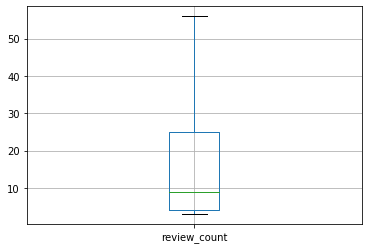

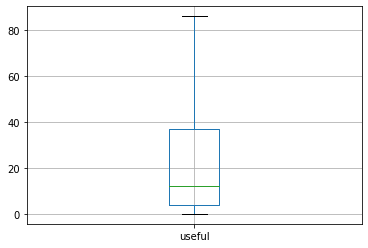

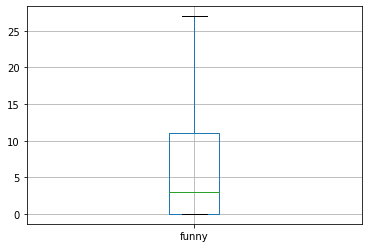

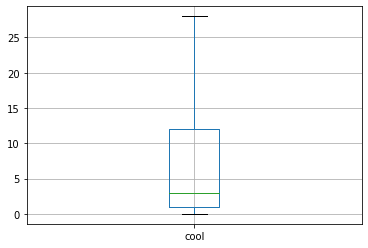

In [43]:
for column in df:
    plt.figure()
    df.boxplot([column], showfliers = False)

In [48]:
b_df = pd.DataFrame(ml_df_3[ml_df_3['is_open']==0][["review_count","useful", "funny", "cool"]].values,
                    columns=["Reviews_no","useful", "funny", "cool"])
bo_df = pd.DataFrame(ml_df_3[ml_df_3['is_open']==1][["review_count","useful", "funny", "cool"]].values,
                    columns=["Reviews_no","useful", "funny", "cool"])
bo_df['Reviews_no'] = bo_df['Reviews_no'].astype(float)
b_df['Reviews_no'] = b_df['Reviews_no'].astype(float)



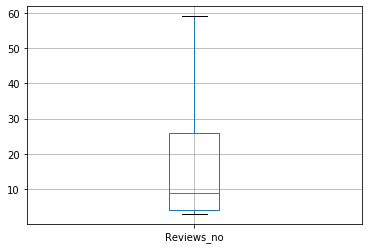

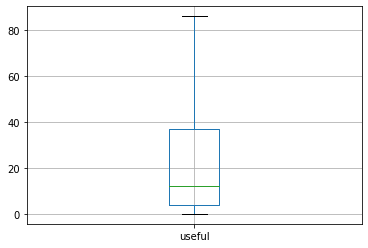

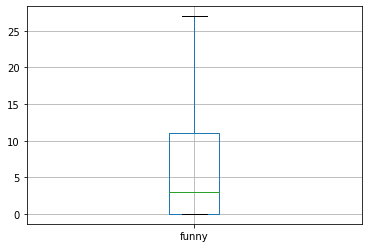

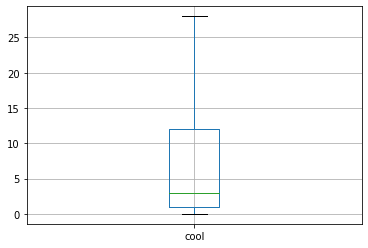

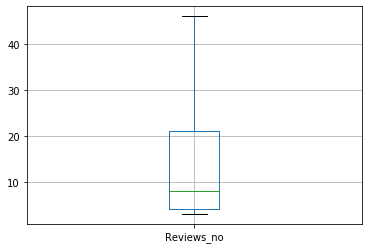

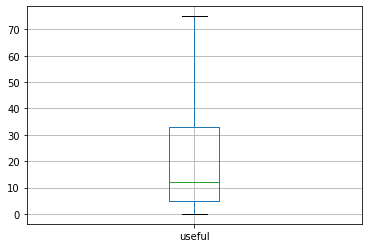

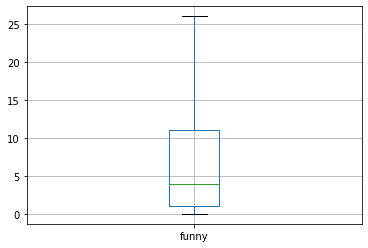

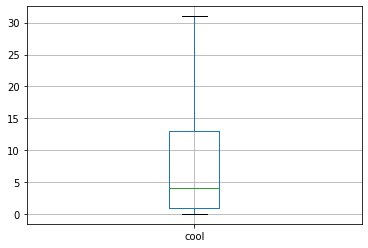

In [49]:
for column in bo_df:
    plt.figure()
    bo_df.boxplot([column], showfliers = False)
    
for column in b_df:
    plt.figure()
    b_df.boxplot([column], showfliers = False)

In [30]:
df.funny.value_counts()

0       50719
1       24859
2       16726
3       11853
4        9382
        ...  
700         1
1852        1
1142        1
573         1
639         1
Name: funny, Length: 879, dtype: int64

In [ ]:
yelp_business.is_open.plot.pie(figsize = (10, 10), startangle = 90)

KeyboardInterrupt: 